In [2]:
import os
base_path = r"C:\Users\ndrmon\Anaconda3"
path = os.pathsep.join([os.path.join(base_path, i) for i in [r"", r"bin", r"Scripts", r"Library\mingw-w64\bin", r"Library\bin"]])
os.environ["PATH"]+=os.pathsep+path

In [3]:
import numpy as np
import pandas as pd
import simpy 
import matplotlib.pyplot as plt
import itertools
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import simpy 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
from IPython.display import HTML
import warnings
import mercury as mr
warnings.simplefilter(action='ignore', category=FutureWarning)


# Simulation X FSA mit gleicher Distribution und separaten Schlangen

In [4]:
import warnings
import mercury as mr
import plotly.express as px
import pandas as pd
warnings.simplefilter(action='ignore', category=Warning)


In [5]:
# set Application parameters
# set Application parameters
app = mr.App(title="Simpi Test App 2",
        description="Simpi Test App",
        show_code=False,
        show_prompt=True,
        continuous_update=True,
        static_notebook=False,
        show_sidebar=True,
        full_screen=True,
        allow_download=True)

mercury.App

In [18]:
def RunSim(NUM_FSA,FGZ_PRO_MIN,SIM_TIME,NUM_RUNS,video_flag='N'):
   
    import numpy as np
    import pandas as pd
    import simpy 
    import matplotlib.pyplot as plt
    import itertools
    from IPython import display
    import pandas as pd
    import numpy as np
    from ipywidgets import interactive
    import matplotlib.pyplot as plt
    import numpy as np
    from ipywidgets import interact, interactive, fixed, interact_manual
    import ipywidgets as widgets
    import simpy 
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import itertools
    from IPython.display import HTML
    import warnings
    #import mercury as mr

    def TicketVerkaufSim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME):
            """A station has a limited number of Fahrscheinautomaten (``NUM_MACHINES``) to
        sellt eh tickets in parallel.

        Fahrgast has to request one of the machines. When they got one, they
        can start the buying processes and wait for it to finish (which
        is described by the Possion distribution as well)."""

            import random
            


            def generate_fg(FGZ_PRO_MIN):
                return np.random.exponential(1.0/FGZ_PRO_MIN) # 10 customer per minute 
            #poisson_random_measure


            def assign_fsa(TICKET_PRO_MIN):
                return np.random.exponential(1.0/TICKET_PRO_MIN) # serve 2 customer per minute 


            #waiting time        
            wait_t={}       
            queues = []
            arr_t=[]    
            fg_ankommen={}
            service_t={}
            start_t={}
            choices={}
            fg_beended={}

            def fg(env,fg, fsas):
                        t_arrival=env.now
                        fg_ankommen[fg]=t_arrival
                        Qlength = {i:NoInSystem(fsas[i]) for i in range(len(fsas))}
                        queues.append({q:len(fsas[q].put_queue) for q in range(len(fsas))})

                        choice=[k for k,v in sorted(Qlength.items(), key=lambda a:a[1])][0]
                        choices[fg]=(choice)

                        with fsas[choice].request() as request:              
                            yield request
                            t_service=env.now
                            start_t[fg]=(t_service)

                            wait_t[fg]=(t_service-t_arrival)

                            yield env.timeout(assign_fsa(NUM_FSA))
                            queues.append({i: len(fsas[i].put_queue) for i in range(len(fsas))})

                            t_depart=env.now
                            service_t[fg]=(t_depart-t_service)

                            fg_beended[fg]=fg


            
            def fsa_run(env):
                i=0
                while True:
                    i+=1
                    yield env.timeout(generate_fg(FGZ_PRO_MIN))
                    env.process(fg(env,i, fsas))

            def NoInSystem(f):
                """Total number of customers in the resource R"""
                return max([0, len(f.put_queue) + len(f.users)])

            
            
            ###Simulation part

            #np.random.seed(RANDOM_SEED) 
            np.random.seed() 

            env=simpy.Environment()
            #generate resources
            fsas={i: simpy.Resource(env) for i in range(NUM_FSA)}
            #run
            env.process(fsa_run(env))
            env.run(until=SIM_TIME)
            
            return wait_t, queues , arr_t, fg_ankommen,service_t,start_t, choices, fg_beended
    def create_output(fg_ankommen,start_t,choices,service_t,wait_t,fg_beended):
        def dfconverter(dict,column,i):
            temp=pd.DataFrame(dict, index=[0]).T.reset_index()
            temp.columns=['fg',column]
            dictlist[i]=temp


        listCol=['arr_t','start_t','fsa','service_t','wait_t','fg_beended']
        listDict=[fg_ankommen,start_t,choices,service_t,wait_t,fg_beended]

        dictlist={}
        for i,x in enumerate(listDict):
            dfconverter(x,listCol[i],i)  
            
        df=dictlist[0].merge(dictlist[1], how='left',on='fg').merge(dictlist[2], how='left',on='fg').merge(dictlist[3], how='left',on='fg').merge(dictlist[4], how='left',on='fg').merge(dictlist[5], how='left',on='fg').sort_values(by='fg')
        ## fg noch in schlange:
        ratio_fg_sch=len(df[df['wait_t'].isna()])/len(df)*100
        fg_ohne_t=len(df[df['wait_t'].isna()])
        df['ratio_fg_sch']=ratio_fg_sch
        df['fg_ohne_t']=fg_ohne_t

        df['wait_t_cl']=np.where(df['wait_t'].isna(),SIM_TIME-df['arr_t'],df['wait_t']) 
        df['start_t_cl']=np.where(((df['service_t'].isna()) & (~df['service_t'].isna())),SIM_TIME-df['start_t'],df['start_t']) 

        #df['wait_t']=df.start_t-df.arr_t
        for i in range(NUM_FSA):
            df['start_t_'+str(i)]=np.where(df['fsa']==i,df['start_t_cl'],0)
            df['service_t_'+str(i)]=np.where(df['fsa']==i,df['service_t'],0) 
        df['wait_mean_sr']=df['wait_t'].mean()
        return df
        
    def mc_sim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME,NUM_RUNS=100):
        output_sim={}
        queues_dict={}
        for i in range(0,NUM_RUNS):
            wait_t, queues , arr_t, fg_ankommen,service_t,start_t, choices, fg_beended=TicketVerkaufSim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME)
            output_sim[i]=create_output(fg_ankommen,start_t,choices,service_t,wait_t,fg_beended)
            queues_dict[i]=queues
        return output_sim,queues_dict

    def bericht(df_output,NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME):
        print('Anzahl FG pro Min:' + str(FGZ_PRO_MIN))
        print('Anzahl FSA:'+ str(NUM_FSA))
        print('Anzahl Tickets pro Minute bei FSA:'+ str(TICKET_PRO_MIN))

        print('Anzahl FG ohne Ticket nach '+ str(SIM_TIME) + ' Minuten:' + str(df_output.fg_ohne_t.mean())+ ' ('+ format(df_output.ratio_fg_sch.mean(),".2f")+'%)')

        print('Druchnitliche Wartezeit in Minuten: '+ format(df_output['wait_t_cl'].mean(),".2f"))
        
    
    def plots(df_output,NUM_FSA):  
        import seaborn as sns        
        import warnings
        
        sns.set_style("whitegrid")

        color=['orange','blue', 'green','yellow','red','brown']


        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        temp=df_output[df_output['sim_nr']==0]
        axes[2].barh(
            y=temp.fg,
            left=temp.arr_t,
            width=temp.wait_t_cl,
            alpha=1.0,
            color="gainsboro", label='Wartezeit')
        for i in range(NUM_FSA):
            axes[2].barh(
                y=temp.fg,
                left=temp['start_t_'+str(i)],
                width=temp['service_t_'+str(i)],
                alpha=1.0,
                color=color[i], label='Zeit beim FSA '+str(i+1))

        axes[2].legend()
        # Set common labels
        axes[2].set_xlabel('Zeit[min]')
        axes[2].set_ylabel('FG Nummer')
        #axes[0].yticks(df.fg.unique().tolist())

        ### Average Queue Time
        plt.grid()

        h=axes[0].hist(df_output.wait_t_cl, bins=20, rwidth=0.9,color='#b0dcf7')
        axes[0].axvline(np.mean(df_output.wait_t_cl), color='red', label='Mean')
        axes[0].text(np.mean(df_output.wait_t_cl)+0.05,0,'Mean '+format((np.mean(df_output.wait_t_cl)), ".2f") ,rotation=90,color='red')
        axes[0].set_xlabel('Wartezeit[min]')
        axes[0].set_ylabel('Anzahl FG nach '+ str(NUM_RUNS) + ' Simulationen')

        k=sns.distplot(df_output.wait_t_cl, ax=axes[1],color='#b0dcf7')
        axes[1].axvline(np.mean(df_output.wait_t_cl), color='red', label='Mean')
        axes[1].text(np.mean(df_output.wait_t_cl)+0.05,0,'Mean '+format((np.mean(df_output.wait_t_cl)), ".2f") ,rotation=90,color='red')
        axes[1].set_xlabel('Wartezeit[min]')
        axes[1].set_ylabel('Wahrscheinlichkeit')


        plt.show()

    def Video(queues_dict,df_output,NUM_FSA,video_flag='N'):
            ### Queues
            color=['orange','blue', 'green','yellow','red','brown']

            q = pd.DataFrame(queues_dict[0])
            temp=df_output[df_output['sim_nr']==0]

            if video_flag=='Y':
                %matplotlib notebook
                %matplotlib inline

                #plt.ioff()
                # animation function 
                numbers = list(itertools.chain(range(0, len(temp))))

                x=[]
                y={}
                for j in range(NUM_FSA):
                    y[j]=[]
                fig3, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
                legend_list=[]
                def animate(i):

                    x.append(numbers[i])
                    for j in range(NUM_FSA):
                        y[j].append((q[j][i]))
                        axes.plot(x, y[j], color=color[j])
                        legend_list.append('FSA'+str(j+1))
                    axes.legend(set(legend_list))

                plt.title("FSA Schlangenaufbau")
                plt.xlabel('FG')
                plt.ylabel('Anzahl FG in der Schlange bei FSA')
                # call the animator	 
                anim = animation.FuncAnimation(fig3, animate, frames=len(temp), interval=800, repeat=False)
                video = anim.to_html5_video()
                html = display.HTML(video)
                display.display(html)

                plt.close()
            else:
                
                #fig3, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
                legend_list=[]
                pd.DataFrame(q).plot()
                
                for j in range(NUM_FSA):
                    legend_list.append('FSA'+str(j+1))
                    
                plt.legend(set(legend_list))

                plt.title("FSA Schlangenaufbau")
                plt.xlabel('FG')
                plt.ylabel('Anzahl FG in der Schlange bei FSA')
                plt.show()
            

    
    output_sim,queues_dict=mc_sim(NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME,NUM_RUNS)
    
    df_output=pd.concat(output_sim).reset_index().drop('level_1', axis=1).rename(columns={'level_0':'sim_nr'})
        
    bericht(df_output,NUM_FSA,FGZ_PRO_MIN,TICKET_PRO_MIN,SIM_TIME) 
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plots(df_output,NUM_FSA)
    Video(queues_dict,df_output,NUM_FSA,video_flag)



In [19]:
NUM_FSA = mr.Slider(value=3, min=1, max=6, label="Anzahl FSA", step=1)
FGZ_PRO_MIN= mr.Slider(value=15, min=1, max=30, label="Anzahl FG pro Minute", step=1)
SIM_TIME= mr.Slider(value=5, min=2, max=15, label="Zeitraum", step=1)
TICKET_PRO_MIN=mr.Slider(value=3, min=1, max=30, label="Anzahl Tickets pro Minute", step=1)
NUM_RUNS=mr.Slider(value=10, min=1, max=10000, label="MC Runs", step=1)

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

mercury.Slider

In [20]:
video_flag = mr.Select(value="N", choices=['N','Y'], label="Video")


mercury.Select

Anzahl FG pro Min:15
Anzahl FSA:3
Anzahl Tickets pro Minute bei FSA:mercury.Slider
Anzahl FG ohne Ticket nach 5 Minuten:27.404225352112675 (36.62%)
Druchnitliche Wartezeit in Minuten: 0.86


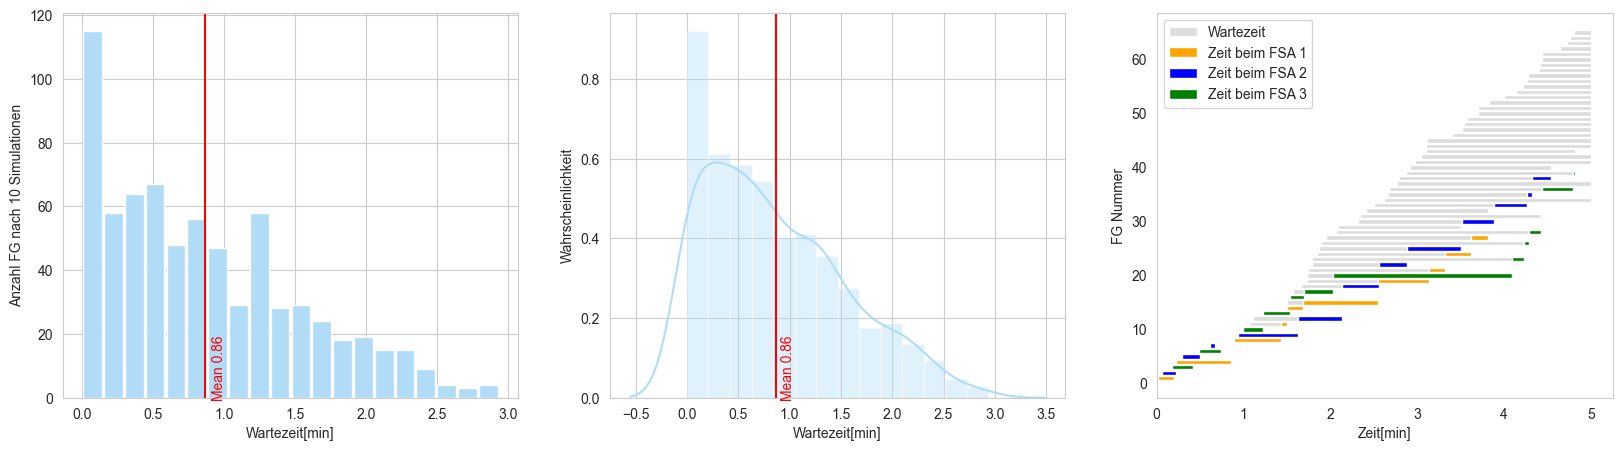

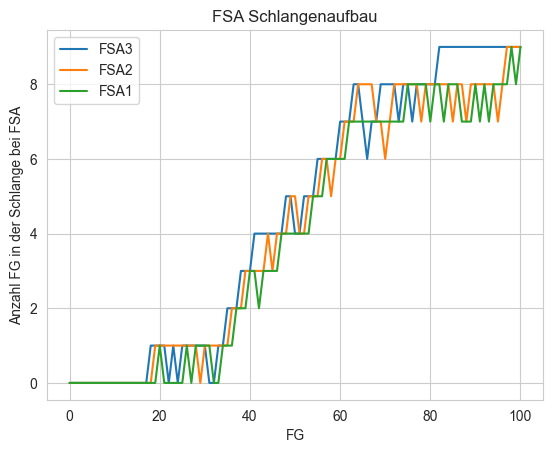

In [21]:
%matplotlib notebook
%matplotlib inline
RunSim(NUM_FSA.value,FGZ_PRO_MIN.value,SIM_TIME.value,NUM_RUNS.value,video_flag.value)